# Notebook 04: SLM Training mit LoRA

## Ziel dieses Notebooks

In diesem Notebook werden wir:

1. **Kleinere SLMs laden** - 3B Parameter Modelle
2. **LoRA-Finetuning** - Parameter-effizientes Training
3. **Training durchführen** - Mit validierten Hyperparametern
4. **Modelle speichern** - Finetuned Versionen für Evaluation

---

## Theoretischer Hintergrund

### Was ist LoRA?

**Low-Rank Adaptation (LoRA)** ist eine Methode für parameter-effizientes Finetuning:

- **Idee**: Statt alle Gewichte zu trainieren, nur niedrigrangige Updates
- **Vorteil**: ~0.1% der Parameter werden trainiert
- **Formel**: $W' = W + BA$ wobei $B \in \mathbb{R}^{d \times r}$, $A \in \mathbb{R}^{r \times k}$

### LoRA-Hyperparameter

| Parameter | Wert | Beschreibung |
|-----------|------|--------------|
| `r` | 64 | Rang der Low-Rank Matrices |
| `alpha` | 128 | Skalierungsfaktor |
| `dropout` | 0.1 | Regularisierung |
| `target_modules` | QKV + FFN | Welche Layer adaptiert werden |

### Unsere SLM-Modelle

| Modell | Größe | Beschreibung |
|--------|-------|--------------|
| Llama-3.2-3B-Instruct | 3B | Kleinste Llama 3.2 Version |
| Qwen2.5-3B-Instruct | 3B | Qwen 2.5 Instruct-Version |

---

In [1]:
# ============================================================
# SETUP: Imports und Umgebung
# ============================================================

import os
import gc
import json
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Optional
from datetime import datetime

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from peft import (
    LoraConfig, 
    get_peft_model, 
    TaskType,
)

print("Imports erfolgreich!")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA verfügbar: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Imports erfolgreich!
   PyTorch: 2.10.0+cu128
   CUDA verfügbar: True
   GPU: NVIDIA GeForce RTX 5090
   VRAM: 33.6 GB


In [ ]:
# ============================================================
# KONFIGURATION (Standalone)
# ============================================================

@dataclass
class PathConfig:
    project_root: Path = field(default_factory=lambda: Path.cwd().parent)
    data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data")
    cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "cache")
    processed_data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "processed")
    models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models")
    finetuned_models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models" / "finetuned")
    checkpoints_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models" / "checkpoints")
    outputs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs")
    logs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "logs")
    
    def create_directories(self):
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Path) and not attr_name.startswith('_'):
                attr.mkdir(parents=True, exist_ok=True)

@dataclass
class DataConfig:
    dataset_name: str = "Ahmad0067/MedSynth"
    dataset_split_seed: int = 42
    train_ratio: float = 0.80
    val_ratio: float = 0.1
    test_ratio: float = 0.1
    # WICHTIG: MedSynth Dialoge haben durchschnittlich ~1167 Tokens
    # 512 würde >99% der Dialoge abschneiden und wichtige Informationen verlieren!
    max_sequence_length: int = 2048  # Erhöht von 512

@dataclass  
class ModelConfig:
    """SLM Modelle für Finetuning."""
    slm_models: List[Dict] = field(default_factory=lambda: [
        {
            "name": "meta-llama/Llama-3.2-3B-Instruct",
            "size": "3B",
            "description": "3B - Small Llama model",
        },
        {
            "name": "Qwen/Qwen2.5-3B-Instruct",
            "size": "3B",
            "description": "3B - Qwen 2.5 model",
        },
    ])

@dataclass
class LoRAConfig:
    """LoRA-Hyperparameter."""
    r: int = 64                    # Rang der Low-Rank Matrices
    lora_alpha: int = 128          # Skalierungsfaktor
    lora_dropout: float = 0.1      # Dropout
    target_modules: List[str] = field(default_factory=lambda: [
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention
        "gate_proj", "up_proj", "down_proj",      # FFN
    ])
    bias: str = "none"
    task_type: str = "CAUSAL_LM"

@dataclass
class TrainingConfig:
    """Training-Hyperparameter."""
    num_train_epochs: int = 3
    per_device_train_batch_size: int = 8   # Reduziert wegen längerer Sequenzen
    per_device_eval_batch_size: int = 8    # Reduziert wegen längerer Sequenzen
    gradient_accumulation_steps: int = 4    # Erhöht für gleiche effektive Batch-Size
    learning_rate: float = 2e-4
    warmup_ratio: float = 0.03
    weight_decay: float = 0.01
    lr_scheduler_type: str = "cosine"
    bf16: bool = True
    fp16: bool = False
    gradient_checkpointing: bool = True
    optim: str = "adamw_torch_fused"
    logging_steps: int = 10
    eval_steps: int = 100
    save_steps: int = 100
    save_total_limit: int = 2
    load_best_model_at_end: bool = True
    metric_for_best_model: str = "eval_loss"
    greater_is_better: bool = False

@dataclass
class Config:
    paths: PathConfig = field(default_factory=PathConfig)
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    lora: LoRAConfig = field(default_factory=LoRAConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    
    def setup(self):
        self.paths.create_directories()
        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

config = Config()
config.setup()

print("Konfiguration geladen!")
print(f"   SLM Modelle: {len(config.model.slm_models)}")
for m in config.model.slm_models:
    print(f"      - {m['name']} ({m['size']})")
print(f"\n   LoRA: r={config.lora.r}, alpha={config.lora.lora_alpha}")
print(f"   Epochs: {config.training.num_train_epochs}")
print(f"   Max Sequence Length: {config.data.max_sequence_length}")
print(f"   Effective Batch Size: {config.training.per_device_train_batch_size * config.training.gradient_accumulation_steps}")

## LoRA-Konfiguration

### LoRA Hyperparameter

| Parameter | Wert | Bedeutung |
|-----------|------|-----------|
| **r (Rank)** | 16-64 | Kapazität der Adapter. Höher = mehr Expressivität, aber mehr Parameter |
| **alpha** | 2×r | Scaling-Faktor. Kontrolliert wie stark LoRA das Modell beeinflusst |
| **dropout** | 0.05-0.1 | Regularisierung. Verhindert Overfitting |
| **target_modules** | ["q_proj", "v_proj", ...] | Welche Layer modifiziert werden |

## 1. Utility-Funktionen

In [3]:
# ============================================================
# UTILITY-FUNKTIONEN (Standalone)
# ============================================================

def get_device() -> str:
    """Bestimmt das beste verfügbare Device."""
    if torch.cuda.is_available():
        return "cuda"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

def aggressive_memory_cleanup():
    """Aggressive Memory-Cleanup."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        torch.cuda.ipc_collect()

def log_gpu_memory(prefix: str = ""):
    """Loggt GPU Memory Status."""
    if not torch.cuda.is_available():
        return
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    msg = f"GPU: {allocated:.2f}GB alloc, {reserved:.2f}GB reserved"
    if prefix:
        msg = f"{prefix} - {msg}"
    print(msg)

print(f"Device: {get_device()}")
log_gpu_memory("Initial")

Device: cuda
Initial - GPU: 0.00GB alloc, 0.00GB reserved


## 2. Data Processor für Training

In [ ]:
# ============================================================
# MEDICAL DIALOG PROCESSOR (Standalone)
# ============================================================

class MedicalDialogProcessor:
    """Formatiert Dialoge für Training und Inference."""
    
    SYSTEM_PROMPT = """You are a medical assistance system that supports doctors in making diagnoses. 
Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue.
Respond only with the ICD-10 code, without further explanation."""
    
    def __init__(self, tokenizer, max_length: int = 2048):
        """
        Args:
            tokenizer: HuggingFace Tokenizer
            max_length: Maximale Sequenzlänge (Default: 2048 für MedSynth)
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def format_dialog_for_training(self, conversation: str, icd_code: str) -> str:
        """Formatiert Dialog für Training (mit Antwort)."""
        user_prompt = f"""Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

{conversation}

ICD-10 Code:"""
        
        if hasattr(self.tokenizer, 'chat_template') and self.tokenizer.chat_template:
            messages = [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": icd_code},
            ]
            try:
                return self.tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=False
                )
            except:
                pass
        
        return f"System: {self.SYSTEM_PROMPT}\n\nUser: {user_prompt}\n\nAssistant: {icd_code}"
    
    def tokenize_function(self, examples: Dict) -> Dict:
        """Tokenisiert Beispiele."""
        dialog_field = 'Dialogue' if 'Dialogue' in examples else 'dialogue'
        icd_field = 'ICD10' if 'ICD10' in examples else 'icd10'
        
        if isinstance(examples[dialog_field], list):
            texts = [
                self.format_dialog_for_training(conv, icd)
                for conv, icd in zip(examples[dialog_field], examples[icd_field])
            ]
        else:
            texts = [self.format_dialog_for_training(
                examples[dialog_field], examples[icd_field]
            )]
        
        tokenized = self.tokenizer(
            texts,
            truncation=True,
            max_length=self.max_length,
            padding=False,  # Dynamisches Padding ist effizienter
            return_tensors=None,
        )
        
        tokenized["labels"] = tokenized["input_ids"].copy()
        
        return tokenized
    
    def process_dataset(self, dataset: Dataset) -> Dataset:
        """Verarbeitet gesamten Dataset."""
        return dataset.map(
            self.tokenize_function,
            batched=True,
            remove_columns=dataset.column_names,
            desc="Tokenisiere Dataset",
        )

print("MedicalDialogProcessor definiert!")

## 3. FineTuner-Klasse

In [5]:
# ============================================================
# FINETUNER-KLASSE (Standalone)
# ============================================================

class FineTuner:
    """
    LoRA FineTuner für SLMs.
    
    Features:
    - Parameter-effizientes Training
    - Gradient Checkpointing
    - BF16/FP16 Training
    """
    
    def __init__(
        self,
        model_name: str,
        config: Config,
        output_dir: Optional[Path] = None,
    ):
        self.model_name = model_name
        self.config = config
        self.model_short = model_name.split("/")[-1]
        
        if output_dir is None:
            output_dir = config.paths.finetuned_models_dir / self.model_short
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        self.model = None
        self.tokenizer = None
        self.processor = None
        self.trainer = None
    
    def load_base_model(self):
        """Lädt Base-Modell und Tokenizer."""
        print(f"📥 Lade Base-Modell: {self.model_name}")
        
        # Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = "right"  # Für Training
        
        # Modell
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )
        
        # Gradient Checkpointing
        if self.config.training.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
            if hasattr(self.model, 'enable_input_require_grads'):
                self.model.enable_input_require_grads()
        
        print("Base-Modell geladen!")
        log_gpu_memory("Nach Laden")
    
    def apply_lora(self):
        """Wendet LoRA auf Modell an."""
        print(f"🔧 Wende LoRA an (r={self.config.lora.r}, alpha={self.config.lora.lora_alpha})")
        
        lora_config = LoraConfig(
            r=self.config.lora.r,
            lora_alpha=self.config.lora.lora_alpha,
            lora_dropout=self.config.lora.lora_dropout,
            target_modules=self.config.lora.target_modules,
            bias=self.config.lora.bias,
            task_type=TaskType.CAUSAL_LM,
        )
        
        self.model = get_peft_model(self.model, lora_config)
        
        # Trainable Parameter anzeigen
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.model.parameters())
        
        print(f"LoRA angewendet!")
        print(f"   Trainable: {trainable:,} ({100*trainable/total:.2f}%)")
        print(f"   Total: {total:,}")
    
    def prepare_data(self, train_dataset: Dataset, val_dataset: Dataset):
        """Bereitet Daten für Training vor."""
        print("Bereite Daten vor...")
        
        self.processor = MedicalDialogProcessor(
            self.tokenizer, 
            max_length=self.config.data.max_sequence_length
        )
        
        self.train_data = self.processor.process_dataset(train_dataset)
        self.val_data = self.processor.process_dataset(val_dataset)
        
        print(f"Daten vorbereitet!")
        print(f"   Train: {len(self.train_data):,} samples")
        print(f"   Val: {len(self.val_data):,} samples")
    
    def setup_trainer(self):
        """Erstellt Trainer."""
        print("Erstelle Trainer...")
        
        training_args = TrainingArguments(
            output_dir=str(self.output_dir),
            num_train_epochs=self.config.training.num_train_epochs,
            per_device_train_batch_size=self.config.training.per_device_train_batch_size,
            per_device_eval_batch_size=self.config.training.per_device_eval_batch_size,
            gradient_accumulation_steps=self.config.training.gradient_accumulation_steps,
            learning_rate=self.config.training.learning_rate,
            warmup_ratio=self.config.training.warmup_ratio,
            weight_decay=self.config.training.weight_decay,
            lr_scheduler_type=self.config.training.lr_scheduler_type,
            bf16=self.config.training.bf16,
            fp16=self.config.training.fp16,
            gradient_checkpointing=self.config.training.gradient_checkpointing,
            optim=self.config.training.optim,
            logging_steps=self.config.training.logging_steps,
            eval_strategy="steps",
            eval_steps=self.config.training.eval_steps,
            save_steps=self.config.training.save_steps,
            save_total_limit=self.config.training.save_total_limit,
            load_best_model_at_end=self.config.training.load_best_model_at_end,
            metric_for_best_model=self.config.training.metric_for_best_model,
            greater_is_better=self.config.training.greater_is_better,
            report_to="none",  # Disable wandb
            logging_dir=str(self.config.paths.logs_dir),
            remove_unused_columns=False,
        )
        
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False,
        )
        
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_data,
            eval_dataset=self.val_data,
            data_collator=data_collator,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )
        
        print("Trainer erstellt!")
    
    def train(self):
        """Startet Training."""
        print(f"\n{'='*60}")
        print(f"Starte Training: {self.model_short}")
        print(f"{'='*60}")
        
        train_result = self.trainer.train()
        
        print(f"\nTraining abgeschlossen!")
        print(f"   Steps: {train_result.global_step}")
        print(f"   Loss: {train_result.training_loss:.4f}")
        
        return train_result
    
    def save_model(self):
        """Speichert finetuned Modell."""
        print(f"Speichere Modell: {self.output_dir}")
        
        # LoRA Adapter speichern
        self.model.save_pretrained(self.output_dir)
        self.tokenizer.save_pretrained(self.output_dir)
        
        # Merged Model speichern (für einfachere Inference)
        merged_dir = self.output_dir / "merged"
        merged_dir.mkdir(exist_ok=True)
        
        # Merge LoRA
        merged_model = self.model.merge_and_unload()
        merged_model.save_pretrained(merged_dir)
        self.tokenizer.save_pretrained(merged_dir)
        
        print(f"Modell gespeichert!")
        print(f"   Adapter: {self.output_dir}")
        print(f"   Merged: {merged_dir}")
    
    def cleanup(self):
        """Cleanup nach Training."""
        if self.model is not None:
            del self.model
            self.model = None
        if self.trainer is not None:
            del self.trainer
            self.trainer = None
        aggressive_memory_cleanup()
        print("Cleanup abgeschlossen")
        log_gpu_memory("Nach Cleanup")

print("FineTuner-Klasse definiert!")

FineTuner-Klasse definiert!


## Training vorbereiten

| Parameter | Bedeutung | Unser Wert |
|-----------|-----------|------------|
| `num_train_epochs` | Durchläufe durch Datensatz | 3 |
| `learning_rate` | Schrittgröße | 2e-4 |
| `per_device_train_batch_size` | Samples pro GPU pro Schritt | 24 |
| `gradient_accumulation_steps` | Akkumulierte Batches | 1 |
| `warmup_steps` | LR-Warmup | 100 |
| `eval_strategy` | Wann evaluieren | "steps" |
| `save_strategy` | Wann speichern | "steps" |

## 4. Trainingsdaten laden

In [6]:
# ============================================================
# TRAININGSDATEN LADEN
# ============================================================

# Versuche gespeicherte Daten zu laden
train_path = config.paths.processed_data_dir / "train_raw"
val_path = config.paths.processed_data_dir / "val_raw"

if train_path.exists() and val_path.exists():
    print(f"Lade gespeicherte Daten...")
    train_data = load_from_disk(str(train_path))
    val_data = load_from_disk(str(val_path))
else:
    print(f"Lade Dataset von HuggingFace und splitte...")
    dataset = load_dataset(config.data.dataset_name, cache_dir=str(config.paths.cache_dir))
    
    if isinstance(dataset, DatasetDict):
        dataset = dataset["train"] if "train" in dataset else dataset[list(dataset.keys())[0]]
    
    # Split
    train_test = dataset.train_test_split(test_size=0.30, seed=config.data.dataset_split_seed)
    val_test = train_test["test"].train_test_split(test_size=0.50, seed=config.data.dataset_split_seed)
    
    train_data = train_test["train"]
    val_data = val_test["train"]
    
    # Speichern
    train_data.save_to_disk(str(train_path))
    val_data.save_to_disk(str(val_path))
    print(f"Daten gespeichert")

print(f"\nDaten geladen!")
print(f"   Train: {len(train_data):,} samples")
print(f"   Val: {len(val_data):,} samples")

Lade gespeicherte Daten...

Daten geladen!
   Train: 7,168 samples
   Val: 1,536 samples


## 5. Erstes SLM trainieren

In [7]:
# ============================================================
# ERSTES SLM TRAINIEREN
# ============================================================

training_results = {}

# Erstes Modell
slm_config_1 = config.model.slm_models[0]
print(f"\n{'='*60}")
print(f"Modell 1: {slm_config_1['name']}")
print(f"{'='*60}")

finetuner_1 = FineTuner(
    model_name=slm_config_1["name"],
    config=config,
)

# Training Pipeline
finetuner_1.load_base_model()
finetuner_1.apply_lora()
finetuner_1.prepare_data(train_data, val_data)
finetuner_1.setup_trainer()
result_1 = finetuner_1.train()
finetuner_1.save_model()

# Ergebnis speichern
training_results[slm_config_1["name"]] = {
    "model_name": slm_config_1["name"],
    "model_size": slm_config_1["size"],
    "training_loss": result_1.training_loss,
    "global_step": result_1.global_step,
    "output_dir": str(finetuner_1.output_dir),
}

# Cleanup
finetuner_1.cleanup()


Modell 1: meta-llama/Llama-3.2-3B-Instruct
📥 Lade Base-Modell: meta-llama/Llama-3.2-3B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 254/254 [00:00<00:00, 400.52it/s, Materializing param=model.norm.weight]                              


Base-Modell geladen!
Nach Laden - GPU: 6.43GB alloc, 6.44GB reserved
🔧 Wende LoRA an (r=64, alpha=128)


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


LoRA angewendet!
   Trainable: 97,255,424 (2.94%)
   Total: 3,310,005,248
Bereite Daten vor...
Daten vorbereitet!
   Train: 7,168 samples
   Val: 1,536 samples
Erstelle Trainer...
Trainer erstellt!

Starte Training: Llama-3.2-3B-Instruct


Step,Training Loss,Validation Loss


: 

In [7]:
# ============================================================
# ZWEITES SLM TRAINIEREN
# ============================================================

if len(config.model.slm_models) > 1:
    slm_config_2 = config.model.slm_models[1]
    print(f"\n{'='*60}")
    print(f"Modell 2: {slm_config_2['name']}")
    print(f"{'='*60}")
    
    finetuner_2 = FineTuner(
        model_name=slm_config_2["name"],
        config=config,
    )
    
    # Training Pipeline
    finetuner_2.load_base_model()
    finetuner_2.apply_lora()
    finetuner_2.prepare_data(train_data, val_data)
    finetuner_2.setup_trainer()
    result_2 = finetuner_2.train()
    finetuner_2.save_model()
    
    # Ergebnis speichern
    training_results[slm_config_2["name"]] = {
        "model_name": slm_config_2["name"],
        "model_size": slm_config_2["size"],
        "training_loss": result_2.training_loss,
        "global_step": result_2.global_step,
        "output_dir": str(finetuner_2.output_dir),
    }
    
    # Cleanup
    finetuner_2.cleanup()
else:
    print("Nur ein SLM konfiguriert")


Modell 2: Qwen/Qwen2.5-3B-Instruct
📥 Lade Base-Modell: Qwen/Qwen2.5-3B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 434/434 [00:00<00:00, 644.06it/s, Materializing param=model.norm.weight]                              


Base-Modell geladen!
Nach Laden - GPU: 6.17GB alloc, 6.26GB reserved
🔧 Wende LoRA an (r=64, alpha=128)
LoRA angewendet!
   Trainable: 119,734,272 (3.74%)
   Total: 3,205,672,960
Bereite Daten vor...


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Daten vorbereitet!
   Train: 7,168 samples
   Val: 1,536 samples
Erstelle Trainer...
Trainer erstellt!

Starte Training: Qwen2.5-3B-Instruct


Step,Training Loss,Validation Loss
100,0.675417,0.684779
200,0.647531,0.654795
300,0.635059,0.638873
400,0.585515,0.633117
500,0.575008,0.625780
600,0.570120,0.618052
700,0.561110,0.609637
800,0.495462,0.620692
900,0.504392,0.619704



Training abgeschlossen!
   Steps: 900
   Loss: 0.6061
Speichere Modell: /home/bmw/src/simon/finetuning/models/finetuned/Qwen2.5-3B-Instruct


Writing model shards: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]

Modell gespeichert!
   Adapter: /home/bmw/src/simon/finetuning/models/finetuned/Qwen2.5-3B-Instruct
   Merged: /home/bmw/src/simon/finetuning/models/finetuned/Qwen2.5-3B-Instruct/merged


NameError: name 'training_results' is not defined

## 6. Training-Ergebnisse visualisieren

Training-Ergebnisse:
             Modell Größe   Loss  Steps
Qwen2.5-3B-Instruct    3B 0.6061    900


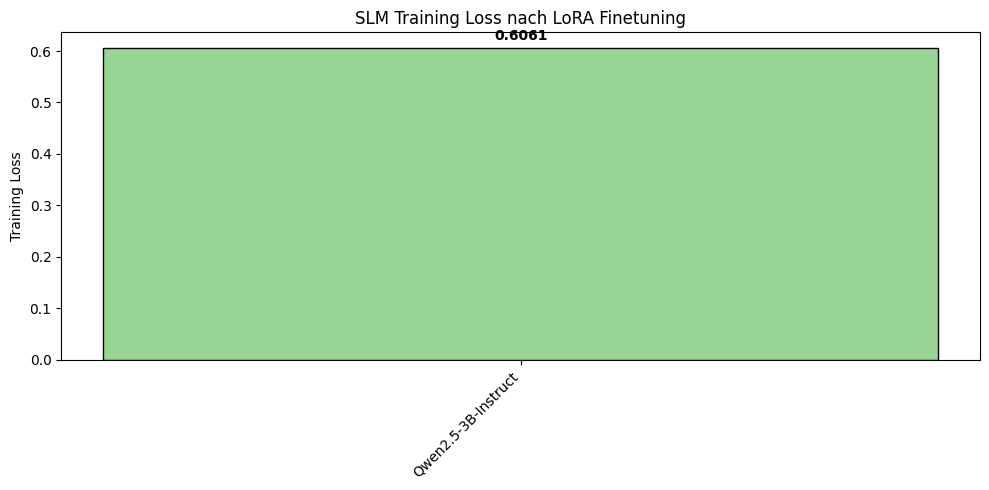

Plot gespeichert!


In [12]:
# ============================================================
# TRAINING-ERGEBNISSE VISUALISIEREN
# ============================================================

print("Training-Ergebnisse:")
print("=" * 60)

results_df = pd.DataFrame([
    {
        "Modell": result["model_name"].split("/")[-1],
        "Größe": result["model_size"],
        "Loss": result["training_loss"],
        "Steps": result["global_step"],
    }
    for result in training_results.values()
])

print(results_df.to_string(index=False))

# Visualisierung
fig, ax = plt.subplots(figsize=(10, 5))

models = [r["model_name"].split("/")[-1] for r in training_results.values()]
losses = [r["training_loss"] for r in training_results.values()]

colors = plt.cm.Greens(np.linspace(0.4, 0.8, len(models)))
bars = ax.bar(range(len(models)), losses, color=colors, edgecolor='black')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('Training Loss')
ax.set_title('SLM Training Loss nach LoRA Finetuning')

for bar, loss in zip(bars, losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{loss:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(config.paths.outputs_dir / 'plots' / 'slm_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot gespeichert!")

## 7. Ergebnisse speichern

In [13]:
# ============================================================
# ERGEBNISSE SPEICHERN
# ============================================================

# Training Results
results_path = config.paths.outputs_dir / 'reports' / 'slm_training_results.json'
results_path.parent.mkdir(parents=True, exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(training_results, f, indent=2, default=str)

print(f"Training-Ergebnisse gespeichert: {results_path}")

# Summary
summary = {
    "training_type": "LoRA Finetuning",
    "lora_r": config.lora.r,
    "lora_alpha": config.lora.lora_alpha,
    "epochs": config.training.num_train_epochs,
    "learning_rate": config.training.learning_rate,
    "models_trained": len(training_results),
    "trained_at": datetime.now().isoformat(),
}

summary_path = config.paths.outputs_dir / 'reports' / 'slm_training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary gespeichert: {summary_path}")

Training-Ergebnisse gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/slm_training_results.json
Summary gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/slm_training_summary.json


In [14]:
# ============================================================
# FINALE ZUSAMMENFASSUNG
# ============================================================

print("=" * 60)
print("ZUSAMMENFASSUNG: SLM LoRA Training")
print("=" * 60)
print(f"""
Training abgeschlossen!

Trainierte Modelle: {len(training_results)}
""")

for name, result in training_results.items():
    short = name.split("/")[-1]
    print(f"   • {short}:")
    print(f"     Loss: {result['training_loss']:.4f}")
    print(f"     Output: {result['output_dir']}")

print(f"""
LoRA-Konfiguration:
   r={config.lora.r}, alpha={config.lora.lora_alpha}
   Target: {config.lora.target_modules}

Training-Konfiguration:
   Epochs: {config.training.num_train_epochs}
   LR: {config.training.learning_rate}
   Batch: {config.training.per_device_train_batch_size} x {config.training.gradient_accumulation_steps}

Gespeicherte Modelle:
""")

for name, result in training_results.items():
    print(f"   • {result['output_dir']}")

print(f"""
Nächster Schritt: Notebook 05 - SLM Evaluation (Finetuned)
""")

ZUSAMMENFASSUNG: SLM LoRA Training

Training abgeschlossen!

Trainierte Modelle: 1

   • Qwen2.5-3B-Instruct:
     Loss: 0.6061
     Output: /home/bmw/src/simon/finetuning/models/finetuned/Qwen2.5-3B-Instruct

LoRA-Konfiguration:
   r=64, alpha=128
   Target: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']

Training-Konfiguration:
   Epochs: 3
   LR: 0.0002
   Batch: 20 x 1

Gespeicherte Modelle:

   • /home/bmw/src/simon/finetuning/models/finetuned/Qwen2.5-3B-Instruct

Nächster Schritt: Notebook 05 - SLM Evaluation (Finetuned)

